In [1]:


# load ens xtc and generate kde (usinb guessed bw)
# sample the kde with MCMC (as many samples as the original data)
# to be more efficient we kean use FFTKDE first and then use a spline on it to compute it at a specific point
# construct new kde with sampled data (using same bw)
# compute residuals of the two kdes

# this is the value of the function that we want to minimize



In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from KDEpy import FFTKDE
import mdtraj as mdt
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize, basinhopping

import sys
sys.path.append("../../")
from cmap import build_phipsi, extend_phipsi, make_grid

In [2]:
ens_basepath = "/data/gzappavigna/lmp_conf_builder/runs/"
ens_traj = mdt.load(ens_basepath + "ensemble.xtc", top=ens_basepath + "cg.pdb")


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


In [3]:
ens_phipsis = build_phipsi(ens_traj)
# nsamples = ens_phipsis.shape[1]
# frac = 0.1

resolution = 32

grid, angles, slc = make_grid(resolution, 1, 0.0)
extent=[angles[0], angles[-1], angles[0], angles[-1]]

# ens_phipsis = [extend_phipsi(ens_phipsi, frac) for ens_phipsi in ens_phipsis]


In [4]:
grid, angles, _ = make_grid(resolution, 1, 0.0)
extent=[angles[0], angles[-1], angles[0], angles[-1]]

def eval_kde(bw, ref_samples, grid):
    kde = FFTKDE(bw=bw)
    kde.fit(ref_samples)

    prob = kde.evaluate(grid.reshape(-1, 2))
    prob = prob.reshape(resolution + 1 , resolution + 1)
    return prob



In [5]:
from math import ceil


def log_prob(x, interp):
    # print(x.shape)
    mask = np.any((x < -np.pi) | (x > np.pi), axis=1)
    x[mask, :] = np.array([0.0, 0.0])
    logp = interp(x)
    # logp = np.log(interp(x) + tiny)
    logp[mask] = -np.inf
    return logp


def sample_from_kde(angles, prob, nsamples):
    method = "slinear"
    tiny = np.finfo(prob.dtype).tiny
    interp = RegularGridInterpolator((angles, angles), np.log(prob + tiny), method=method)

    ndim = 2
    nwalkers = 25
    samples_per_chain = ceil(nsamples / nwalkers)
    p0 = np.pi * (2 * np.random.rand(nwalkers, ndim) - 1)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[interp], vectorize=True)
    # sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[interp], vectorize=False)
    sampler.run_mcmc(p0, 1000 + samples_per_chain)

    samples = sampler.get_chain()
    samples = samples[-samples_per_chain:].reshape(-1, 2)

    return samples


In [7]:
def loss(x, angles, grid, ref_samples):
    bw = x[0]
    print(bw)
    ref_prob = eval_kde(bw, ref_samples, grid)

    nsamples = ref_samples.shape[0]

    reps = 10
    new_samples = sample_from_kde(angles, ref_prob, reps * nsamples)

    out = 0.0
    # for _ in range(10):
    for i in range(0, reps * nsamples, nsamples):
        # new_samples = sample_from_kde(angles, ref_prob, nsamples)
        rec_prob = eval_kde(bw, new_samples[i:i+nsamples], grid)
        out += np.mean((ref_prob - rec_prob) ** 2)

    return out


def callback(intermediate_result):
    print("loss:", intermediate_result.fun)


In [8]:
ens_phipsis[8].shape[0]

1000

In [8]:
res = minimize(loss, x0=[0.6], bounds=[(0.01, 2.0)], args=(angles, grid, ens_phipsis[8]), callback=callback)

0.6
0.60000001
0.01
0.01000001
0.599999879370001
0.599999889370001
0.5999999555879674
0.5999999655879674
loss: 0.002010919257063398
0.5999999009167415
0.5999999109167415
0.5999999342820563
0.5999999442820564
0.5999999535882571
0.5999999635882571
0.5999999555565904
0.5999999655565904


KeyboardInterrupt: 

In [ ]:
res = basinhopping(loss, x0=[2.0], minimizer_kwargs=dict(bounds=[(1e-10, None)], args=(angles, grid, ens_phipsis[8]), callback=callback))

In [30]:
bws = np.linspace(0.1, 0.4, 30)

errs = [loss([bw], angles, grid, ens_phipsis[8]) for bw in bws]

0.1
0.11034482758620691
0.1206896551724138
0.1310344827586207
0.1413793103448276
0.1517241379310345
0.1620689655172414
0.1724137931034483
0.1827586206896552
0.1931034482758621
0.20344827586206898
0.2137931034482759
0.2241379310344828
0.23448275862068968
0.24482758620689657
0.2551724137931035
0.2655172413793104
0.27586206896551724
0.28620689655172415
0.29655172413793107
0.306896551724138
0.3172413793103449
0.32758620689655177
0.33793103448275863
0.34827586206896555
0.35862068965517246
0.3689655172413794
0.3793103448275863
0.3896551724137931
0.4


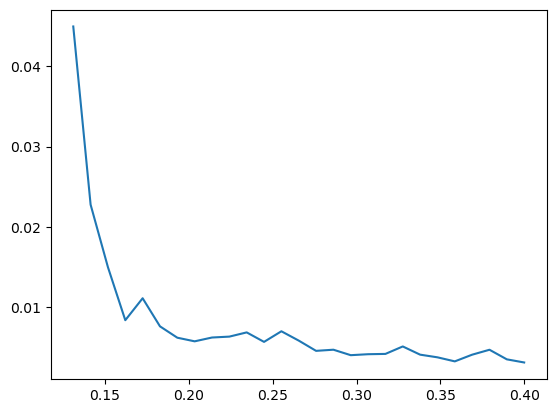

In [31]:
plt.plot(bws[3:], errs[3:]) #+ bws[3:])